In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn

## Imports
import os
import sys
import matplotlib.pyplot as plt
import pickle

In [ ]:

from src.utils.logger import Logging
from src.nn.pde import helmholtz_operator
from src.utils.plot_prediction import plt_prediction
from src.data.helmholtz_dataset import u, f
from src.nn.DVPDESolver import DVPDESolver
from src.nn.CVPDESolver import CVPDESolver
from src.nn.ClassicalSolver import ClassicalSolver
from src.trainer.helmholtz_train import helmholtz_train

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'    # for no GPUs


## Gates supported by strawberryfields.fock


In [14]:
DEVICE = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

A1 = 1
A2 = 4
LAMBDA = 1.0

num_points = 50

dom_coords = torch.tensor([[-1.0, -1.0], [1.0, 1.0]], dtype=torch.float32).to(DEVICE)

t = (
    torch.linspace(dom_coords[0, 0], dom_coords[1, 0], num_points)
    .to(DEVICE)
    .unsqueeze(1)
)

x = (
    torch.linspace(dom_coords[0, 1], dom_coords[1, 1], num_points)
    .to(DEVICE)
    .unsqueeze(1)
)
t, x = torch.meshgrid(t.squeeze(), x.squeeze())
X_star = torch.hstack((t.flatten().unsqueeze(1), x.flatten().unsqueeze(1))).to(DEVICE)

In [20]:

mode = "hybrid"
num_qubits = 5
output_dim = 1
input_dim = 2
hidden_dim = 50
num_quantum_layers = 1
cutoff_dim = 10
classic_network = [input_dim, hidden_dim, output_dim]


args = {
    "batch_size": 64,
    "epochs": 20000,
    "lr": 0.0001,
    "seed": 1,
    "print_every": 100,
    "log_path": "./checkpoints/helmholtz",
    "input_dim": input_dim,
    "output_dim": output_dim,
    "num_qubits": num_qubits,
    "hidden_dim": hidden_dim,
    "num_quantum_layers": num_quantum_layers,
    "classic_network": classic_network,
    "q_ansatz": "layered_circuit",  # options: "alternating_layer_tdcnot", "abbas" , farhi , sim_circ_13_half, sim_circ_13 , sim_circ_14_half, sim_circ_14 , sim_circ_15 ,sim_circ_19
    "mode": mode,
    "activation": "tanh",  # options: "null", "partial_measurement_half" , partial_measurement_x
    "shots": None,  # Analytical gradients enabled
    "problem": "helmholtz",
    "solver": "DV",
    "device": DEVICE,
    "method": "None",
    "cutoff_dim": cutoff_dim,  # num_qubits >= cutoff_dim
    "class": "DV_layered_circuit",  # options : "DVQuantumLayer", "CVQuantumLayer", "Enhanced_CVQuantumLayer"
    "encoding": "angle",
}


In [16]:
log_path = args["log_path"]
logger = Logging(log_path)

In [21]:
# model = CavityHybridPINN(args, logger, data=train_dataloader)

if args["solver"] == "CV":
    model = CVPDESolver(args, logger, X_star, DEVICE)
else:
    model = DVPDESolver(args, logger, X_star, DEVICE)

# Training loop
logger.print(f"The settings used: {args}")
for key, value in args.items():
    logger.print(f"{key} : {value}")

# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

INFO:src.utils.logger:The settings used: {'batch_size': 64, 'epochs': 20000, 'lr': 0.0001, 'seed': 1, 'print_every': 100, 'log_path': './checkpoints/helmholtz', 'input_dim': 2, 'output_dim': 1, 'num_qubits': 5, 'hidden_dim': 50, 'num_quantum_layers': 1, 'classic_network': [2, 50, 1], 'q_ansatz': 'layered_circuit', 'mode': 'hybrid', 'activation': 'tanh', 'shots': None, 'problem': 'helmholtz', 'solver': 'DV', 'device': 'cpu', 'method': 'None', 'cutoff_dim': 10, 'class': 'DV_layered_circuit', 'encoding': 'angle'}
INFO:src.utils.logger:batch_size : 64
INFO:src.utils.logger:epochs : 20000
INFO:src.utils.logger:lr : 0.0001
INFO:src.utils.logger:seed : 1
INFO:src.utils.logger:print_every : 100
INFO:src.utils.logger:log_path : ./checkpoints/helmholtz
INFO:src.utils.logger:input_dim : 2
INFO:src.utils.logger:output_dim : 1
INFO:src.utils.logger:num_qubits : 5
INFO:src.utils.logger:hidden_dim : 50
INFO:src.utils.logger:num_quantum_layers : 1
INFO:src.utils.logger:classic_network : [2, 50, 1]


INFO:src.utils.logger:q_ansatz : layered_circuit
INFO:src.utils.logger:mode : hybrid
INFO:src.utils.logger:activation : tanh
INFO:src.utils.logger:shots : None
INFO:src.utils.logger:problem : helmholtz
INFO:src.utils.logger:solver : DV
INFO:src.utils.logger:device : cpu
INFO:src.utils.logger:method : None
INFO:src.utils.logger:cutoff_dim : 10
INFO:src.utils.logger:class : DV_layered_circuit
INFO:src.utils.logger:encoding : angle


Total number of parameters: 781


In [ ]:
helmholtz_train.train(model)

INFO:src.utils.logger:The circuit used in the study:


The circuit is saved in ./checkpoints/helmholtz/2025-02-12_12-37-43-650635


INFO:src.utils.logger:Iteration: 0, loss_r = 9.2e+03 ,  loss_bc = 1.5e+00,  lr = 5.0e-03, time_taken = 8.4e+00
INFO:src.utils.logger:Model state saved to ./checkpoints/helmholtz/2025-02-12_12-37-43-650635/model.pth


## Plot loss history

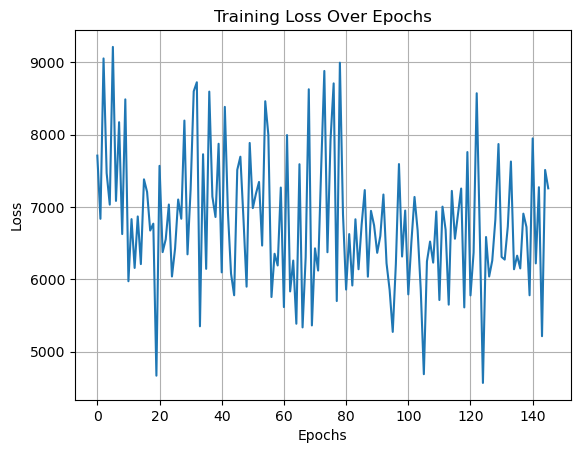

In [ ]:
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)

# Testing


In [ ]:
# Test data
num_points = 10
A1 = 1
A2 = 4
LAMBDA = 1.0

dom_coords = torch.tensor([[-1.0, -1.0], [1.0, 1.0]], dtype=torch.float32).to(DEVICE)

t = (
    torch.linspace(dom_coords[0, 0], dom_coords[1, 0], num_points)
    .to(DEVICE)
    .unsqueeze(1)
)

x = (
    torch.linspace(dom_coords[0, 1], dom_coords[1, 1], num_points)
    .to(DEVICE)
    .unsqueeze(1)
)
t, x = torch.meshgrid(t.squeeze(), x.squeeze())
X_star = torch.hstack((t.flatten().unsqueeze(1), x.flatten().unsqueeze(1))).to(DEVICE)

# Exact solution
u_star = u(X_star, A1, A2)
f_star = f(X_star, A1, A2, LAMBDA)

In [ ]:
# Predictions
u_pred_star, f_pred_star = helmholtz_operator(model, X_star[:, 0:1], X_star[:, 1:2])

u_pred = u_pred_star.cpu().detach().numpy()
f_pred = f_pred_star.cpu().detach().numpy()
u_star = u_star.cpu().detach().numpy()
f_star = f_star.cpu().detach().numpy()
X = X_star.cpu().detach().numpy()

INFO:src.utils.logger:Forward pass failed: 'CVNeuralNetwork' object has no attribute 'rotation_phi1'


AttributeError: 'CVNeuralNetwork' object has no attribute 'rotation_phi1'

INFO:src.utils.logger:Relative L2 error_u: 2.32e+02
INFO:src.utils.logger:Relative L2 error_f: 9.27e+01


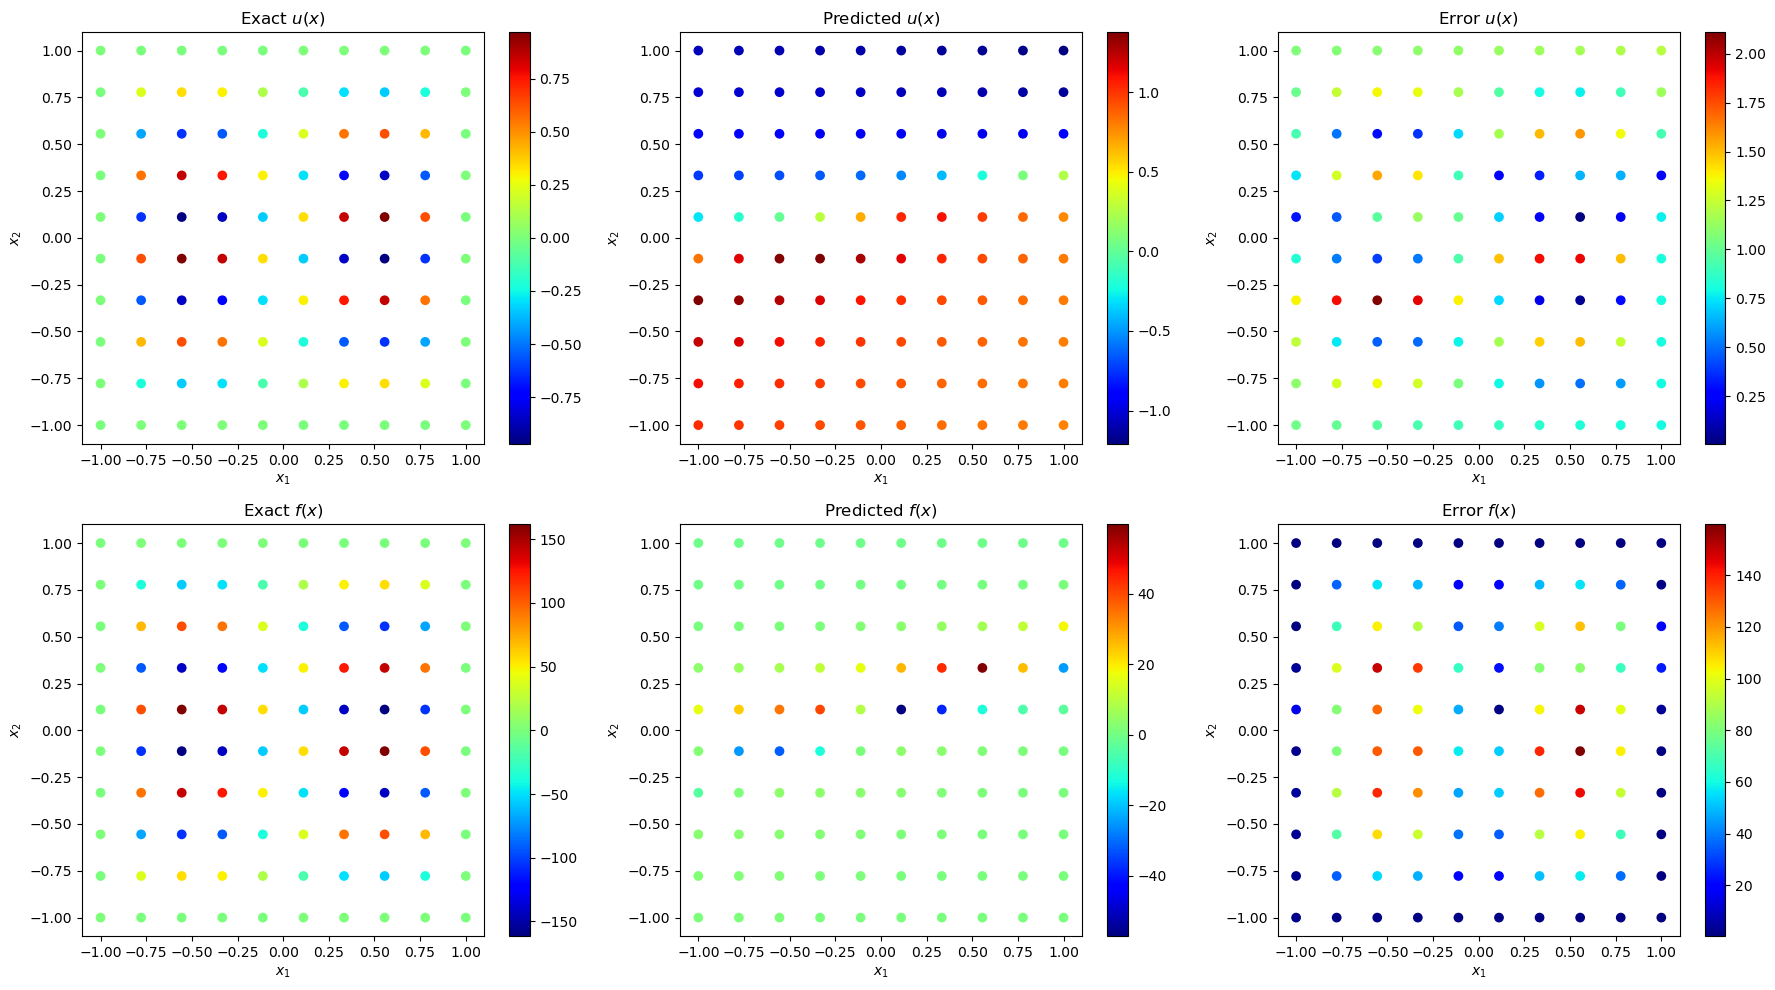

In [ ]:
# Relative L2 error
error_u = np.linalg.norm(u_pred - u_star) / np.linalg.norm(u_star) * 100
error_f = np.linalg.norm(f_pred - f_star) / np.linalg.norm(f_star) * 100
logger.print("Relative L2 error_u: {:.2e}".format(error_u))
logger.print("Relative L2 error_f: {:.2e}".format(error_f))


# Plot predictions
plt_prediction(
    logger,
    X,
    u_star,
    u_pred,
    f_star,
    f_pred,
)
